In [1]:
import multiprocessing as mp
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer

# NN model

In [2]:
class LinearLayer:
    def __init__(self,dim_in,dim_out):
        self.n_in=dim_in
        self.n_out=dim_out
        self.weights=np.random.normal(0,0.01,(dim_in,dim_out))
        self.bias=np.random.normal(0,0.01,dim_out)
        
    def __call__(self,x):
        out=np.matmul(x,self.weights)
        out+=self.bias
        
        return out
    
    def backward(self,x):
        dL=x
        
        return dL

class Sigmoid:
    "sigmoid function"
    
    def __call__(self,x):
        out=1/(1+np.exp(-x))
        
        return out
    
    def backward(self,x):
        out=np.exp(-x)/(1+np.exp(-x))**2
        return out

In [3]:
class NN:
    """ Neural Network with one hidden layer"""
    
    def __init__(self,dim_in,hidden_dim,dim_out):
        self.layer1=LinearLayer(dim_in,hidden_dim)
        self.layer2=LinearLayer(hidden_dim,dim_out)
        self.sig=Sigmoid()
        self.delta=None
        
    def __call__(self,x):
        self.out_l1=self.layer1(x)
        self.out_s1=self.sig(self.out_l1)
        self.out_l2=self.layer2(self.out_s1)
        self.out_s2=self.sig(self.out_l2)
        
        return self.out_s2
    
    def predict(self,x):
        p=self(x)
        
        pred=(p>=0.5).astype('int')
        
        return pred

class logloss:
    
    def __init__(self,model):
        self.model=model
        
    def __call__(self,x,y):
        p=self.model(x)
        L=y*np.log(p)+(1-y)*np.log(1-p)
        
        return -L.sum()/x.shape[0]
    
    def backward(self,x,y):
        p=self.model(x)
        dL=-y/p+(1-y)/(1-p)
        dL=dL/x.shape[0]
        dL=dL*model.sig.backward(model.out_l2)
        dw2,db2=np.dot(model.out_s1.T,dL),dL.sum()
        
        dw1=model.layer2.weights.T*model.sig.backward(model.out_l1)
        db1=(dL*dw1).sum(0)
        dw1=np.dot((dL*x).T,dw1)
        
        model.delta=db1,dw1,db2,dw2
    
class optimizer:
    
    def __init__(self,model,lr=0.01):
        self.model=model
        self.lr=lr
        
    def step(self):
        
        db1,dw1,db2,dw2=model.delta
        self.model.layer1.bias-=db1*self.lr
        self.model.layer1.weights-=dw1*self.lr
        self.model.layer2.bias-=db2*self.lr
        self.model.layer2.weights-=dw2*self.lr

# Training

In [4]:
def train(optimizer,loss,xtrain,ytrain,num_iter=100):
    
    for i in range(num_iter):
        
        L=loss(xtrain,ytrain)
        loss.backward(xtrain,ytrain)
        optimizer.step()
        
        if i%10==0:
            print('Iteration ',i,', loss: ',L)

In [5]:
data=load_breast_cancer()

In [6]:
x=data['data']
y=data['target']

In [12]:
y=y.reshape(-1,1)

In [13]:
model=NN(30,50,1)
loss=logloss(model)
opt=optimizer(model,lr=1)

In [8]:
opt.lr=0.01

In [ ]:
train(opt,loss,x,y,num_iter=100)

In [5]:
def accuracy(y_pred,y_true):
    acc=(y_pred==y_true).sum()
    
    return acc/y_pred.shape[0] 

In [16]:
accuracy(model.predict(x),y)

/home/joao/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater_equal


0.37258347978910367

# Decision boundary

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

In [7]:
sns.set()

In [8]:
n=np.random.normal(0,20,(300,2))
y=np.ones(300)

In [9]:
def d(x):
    r=np.sqrt((x*x).sum(1))
    
    return r

In [10]:
idx=d(n)>25

In [11]:
y[idx]=0

In [12]:
data=pd.DataFrame(data=np.concatenate([n,y.reshape(-1,1)],axis=1),columns=['x','y','target'])
data.target=data.target.astype('int')

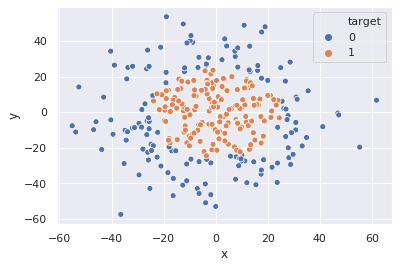

In [13]:
sns.scatterplot(data=data,x='x',y='y',hue='target')
plt.show()

In [62]:
model=NN(2,10,1)
loss=logloss(model)
opt=optimizer(model,lr=0.1)

In [104]:
opt.lr=0.01

In [ ]:
train(opt,loss,n,y.reshape(-1,1),num_iter=1000)

In [119]:
accuracy(model.predict(n),y.reshape(-1,1))

0.9933333333333333

In [42]:
def decision_plot(X,model,ax=None):
    plot_step=0.1
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),
                         np.arange(y_min, y_max, plot_step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    if ax is not None:
        cs = ax.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)
    else:
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.Pastel1)

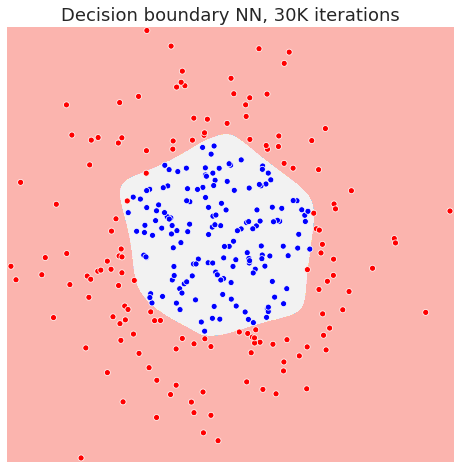

In [121]:
plt.figure(figsize=(8,8))
decision_plot(n,model)
sns.scatterplot(data=data,x='x',y='y',hue='target',legend=False,palette=['red','blue'])
plt.title("Decision boundary NN, 30K iterations",fontsize=18)
plt.axis('off')
plt.savefig('../../pelican-page/content/images/nn_decision_30k.png')
plt.show()